## **Catégorisez automatiquement des questions**

### partie 4/8 : Prédiction de tags, approche supervisée + tracking mlflow

#### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## 1 Import


### 1.1 Librairies


In [27]:
# finir d'organiser, check inutiles ?

#
import os, sys, random
import ast
import numpy as np
import pandas as pd
from typing import Tuple
from pandarallel import pandarallel
from pprint import pprint
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import corpus2dense
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import similarities
from gensim.models.ldamulticore import LdaMulticore

# sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import make_scorer, PredictionErrorDisplay, r2_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)

#
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature, ModelSignature #, Schema, ParamSchema
from mlflow.types import Schema, ParamSchema, ParamSpec, ColSpec

# os.environ['MLFLOW_TRACKING_URI'] = './'

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks

# Utilisable seulement en local...
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1.2 Functions


In [28]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('./forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


In [29]:
def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)



In [30]:
# Again, this needs mlfow ui console command first -> unusable on remote server
# all_experiments = client.search_experiments()
# pprint(all_experiments)


### 1.3 Data


In [31]:
data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(data)

display(data.tail())

print(data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [32]:
train_df, test_df = train_test_split(data, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape)
print(test_df.shape)


(42898, 8)
(4767, 8)


## 2 KNN


In [33]:
# Often gives good results if enough data
# fast
# Accepts basically any input, as long as it is numerical

# => Perfect for testing different embeddings !


### 2.1 Dummy knn : il copie sur le + proche voisin


In [34]:
# Notre baseline

def predict_tags_using_dummy_knn(df, feature, target, k=1, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    # print(knn_model.n_neighbors)

    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +
    # ici a ameliorer

    return predicted_tags, knn_model


exemple = ["your", 'text', 'document', 'javascript']
# Call the function with your DataFrame and the desired text feature and target tags
predicted_tags, knn_test = predict_tags_using_dummy_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple)
print(predicted_tags, '\n')

# javascript ok


['c#', '.net', 'ms-word', 'openxml', 'openxml-sdk']
['c#', '.net', 'ms-word', 'openxml', 'openxml-sdk'] 



### 2.2 knn basic


In [35]:
# add grid search cv
# add score

def predict_tags_using_knn(df, feature, target, k=50, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +
    # ici a ameliorer

    return query_vector, predicted_tags



### 2.3 predictions (input = list)


In [36]:
exemple1 = ["your", 'text', 'document', 'javascript']
_, predicted_tags1 = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple1)
print(predicted_tags1, '\n')

# javascript ok


['c#', '.net', 'ms-word', 'openxml', 'openxml-sdk', 'java', 'javascript', 'ajax', 'selenium', 'htmlunit-driver', 'javascript', 'internet-explorer', 'class', 'internet-explorer-8', 'classname', 'javascript', 'jquery', 'jquery-plugins', 'text-to-speech', 'html5-audio', 'javascript', 'html', 'css', 'text', 'truncate', 'javascript', 'html', 'string', 'text', 'extract', 'javascript', 'jquery', 'css', 'dom', 'document', 'javascript', 'dom', 'substring', 'indexof', 'getselection', 'python', 'text', 'replace', 'ms-word', 'python-docx', 'javascript', 'php', 'jquery', 'curl', 'http-headers', 'javascript', 'html', 'function', 'text', 'onclick', 'python', 'module', 'preprocessor', 'nlp', 'stemming', 'android', 'material-design', 'android-support-library', 'android-textinputlayout', 'android-support-design', 'c#', '.net', 'html', 'pdf', 'extract', 'html', 'url', 'browser', 'full-text-search', 'highlight', 'javascript', 'jquery', 'ruby-on-rails', 'tdd', 'jasmine', 'c#', 'javascript', 'html', 'http',

In [37]:
exemple2 = ["your", 'text', 'document', 'python']
# Call the function with your DataFrame and the desired text feature and target tags
_, predicted_tags2 = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple2)
print(predicted_tags2, '\n')

# python


['python', 'module', 'preprocessor', 'nlp', 'stemming', 'c#', '.net', 'ms-word', 'openxml', 'openxml-sdk', 'python-2.7', 'ubuntu', 'python-3.x', 'spatial-index', 'r-tree', 'python-3.x', 'pdf', 'text', 'extract', 'pdfminer', 'python', 'text', 'stemming', 'plural', 'singular', 'python', 'html', 'web-scraping', 'text', 'beautifulsoup', 'python', 'selenium', 'selenium-webdriver', 'xpath', 'webdriverwait', 'python', 'plot', 'tree', 'data-visualization', 'visualization', 'python', 'pdf', 'python-3.7', 'pypdf', 'pdf-extraction', 'python', 'python-3.x', 'annotations', 'lint', 'type-hinting', 'python', 'python-2.7', 'reflection', 'delegation', 'message-passing', 'python', 'documentation', 'python-3.7', 'docstring', 'python-dataclasses', 'python', 'python-3.x', 'algorithm', 'sorting', 'mergesort', 'python', 'parsing', 'text', 'file-io', 'python-2.7', 'python', 'image', 'opencv', 'image-processing', 'computer-vision', 'python', 'utf-8', 'python-unicode', 'windows-1252', 'cp1252', 'python', 'macos

In [38]:
exemple = test_df['title_nltk'][0]
print(exemple)

# Call the function with your DataFrame and the desired text feature and target tags
_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple)
print(predicted_tags, '\n')

# firebase peut etre predit
# grand succes !


['find', 'class', 'com', 'google', 'firebase', 'provider']
['java', 'spring', 'rest', 'gradle', 'spring-boot', 'android', 'android-studio', 'firebase', 'android-gradle-plugin', 'google-play-services', 'java', 'android', 'firebase', 'gradle', 'android-gradle-plugin', 'android', 'android-intent', 'arraylist', 'unmarshalling', 'parcelable', 'php', 'sql', 'laravel', 'laravel-5', 'laravel-artisan', 'php', 'class', 'laravel', 'alias', 'autoloader', 'java', 'spring', 'spring-boot', 'spring-security', 'spring-security-oauth2', 'android', 'google-maps', 'dictionary', 'android-mapview', 'inflate', 'android', 'firebase', 'android-studio', 'android-gradle-plugin', 'jcenter', 'javascript', 'node.js', 'typescript', 'nestjs', 'class-validator', 'javascript', 'android', 'reactjs', 'react-native', 'gradle', 'java', 'jar', 'maven-2', 'manifest', 'program-entry-point', 'javascript', 'node.js', 'angular', 'typescript', 'angular7', 'c#', '.net', 'web-config', 'class-library', 'configurationmanager', 'ios',

### 2.4 Predictions (input = text)


In [39]:
exemple = test_df['title'][0]
print(exemple)

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple_text)
print(predicted_tags, '\n')

# ok


Didn't find class "com.google.firebase.provider.FirebaseInitProvider"
['java', 'spring', 'rest', 'gradle', 'spring-boot', 'android', 'android-studio', 'firebase', 'android-gradle-plugin', 'google-play-services', 'java', 'android', 'firebase', 'gradle', 'android-gradle-plugin', 'android', 'android-intent', 'arraylist', 'unmarshalling', 'parcelable', 'php', 'sql', 'laravel', 'laravel-5', 'laravel-artisan', 'php', 'class', 'laravel', 'alias', 'autoloader', 'java', 'spring', 'spring-boot', 'spring-security', 'spring-security-oauth2', 'android', 'google-maps', 'dictionary', 'android-mapview', 'inflate', 'android', 'firebase', 'android-studio', 'android-gradle-plugin', 'jcenter', 'javascript', 'node.js', 'typescript', 'nestjs', 'class-validator', 'javascript', 'android', 'reactjs', 'react-native', 'gradle', 'java', 'jar', 'maven-2', 'manifest', 'program-entry-point', 'javascript', 'node.js', 'angular', 'typescript', 'angular7', 'c#', '.net', 'web-config', 'class-library', 'configurationmanag

In [40]:
exemple = test_df['title'][1]
print(exemple)

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(train_df, 'title_nltk', 'all_tags', exemple=exemple_text)
print(predicted_tags, '\n')

# scala ok


Why do I get `java.lang.NoClassDefFoundError: scala/Function1` when I run my code in ScalaIDE?


/tmp/ipykernel_73755/2421486217.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


['c#', '.net', 'wpf', 'code-behind', 'itemspanel', 'reactjs', 'authentication', 'google-authentication', 'google-api-js-client', 'googleauthr', 'java', 'gradle', 'spring-boot', 'jar', 'build.gradle', 'iphone', 'ios', 'xamarin.ios', 'http-response-codes', 'nsurlconnectiondelegate', 'c++', 'python', 'ctypes', 'cython', 'boost-python', 'php', 'mysql', 'laravel', 'ubuntu', 'server', 'c', 'gcc', 'types', 'openmp', 'typeof', 'scala', 'maven', 'apache-spark', 'noclassdeffounderror', 'spark-streaming', 'c', 'assembly', 'x86', 'x86-64', 'shellcode', 'python', 'selenium', 'http', 'selenium-webdriver', 'ui-automation', 'stack-trace', 'glibc', 'sigabrt', 'segmentation-fault', 'backtrace', 'c++', 'c', 'cuda', 'parallel-processing', 'gpu', 'macos', 'shell', 'scala', 'terminal', 'installation', 'c#', 'sql-server', 'asp.net-mvc', 'entity-framework', 'asp.net-mvc-4', 'java', 'selenium', 'testing', 'selenium-webdriver', 'selenium-chromedriver', 'javascript', 'html', 'ajax', 'url', 'xmlhttprequest', 'sca

### 2.5 scores


In [41]:
# Notre objectif de prédiction de tags ressemble a un pb de classification multi-label,
# où la matrice de confusion est extrêmement déséquilibrée :
# 5 tags sont prédits positifs, contre environ 250 000 tags (si on travaille sur all_tags)
# predits negatifs. Autrement dit :

# On peut utiliser la precision pour évaluer notre modèle. C'est même exactement l'outil qu'il nous faut :
# "précision = la proportion de prédictions correctes parmi les points que l’on a prédits positifs."
# En + c de loin le plus léger en ressources, puisqu'il ne s'occupe que des 5 tags prédits.

# En revanche je pense que le recall n'a pas vraiment de sens ici, il sera "écrasé" par
# le nombre de tags predits negatifs, sa valeur sera tjs très proche de zero.
# (même remarque pour la spécificité et l'accuracy)
# Et sans recall, pas de f1 score.
# à vérifier


#### Precision


In [42]:
# pourquoi on ne peut pas utiliser le score precision sckikit ici :
from sklearn.metrics import precision_score as p_score

# Assuming y_true is the ground truth (real tags) and y_pred is the predicted tags
precision = p_score(['ok', 'ko'], ['ko', 'ok'], average='micro')  # You can use 'micro', 'macro', or 'weighted' depending on your use case
print(f'Precision: {precision}')


Precision: 0.0


In [43]:
def precision_topics(real_tags:list, predicted_tags:list): # pour comparer 2 listes
    # precision = TP / (TP + FP)
    tp = 0
    for predicted_tag in predicted_tags:
        if predicted_tag in real_tags:
            tp += 1

    fp = len(predicted_tags) - tp
    precision = tp/(tp + fp)
    # <=> precision = tp/len(predicted_tags)

    return precision


print(precision_topics(exemple1, predicted_tags1))
precision_topics(exemple2, predicted_tags2)

# ok


0.2


0.2

In [44]:
def precision_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    precision = 0
    for i in range(0, len(y_pred)):
        precision += precision_topics(y_true[i], y_pred[i])
    precision_moyenne = precision / len(y_pred)

    return precision_moyenne


# pour la gridsearchcv
custom_precision_scorer = make_scorer(precision_score, greater_is_better=True)


#### Recall


In [45]:
# La precision nous interesse davantage ici, pour au moins 2 raisons :
# 1) On n'a aucune raison de "pénaliser" le modele pour les faux negatifs
# 2) Ici le recall va etre tres proche de zero, et sa variance sera tres faible
# => bcp - parlant

def recall_topics(all_tags: list, predicted_tags: list):
    # recall = TP / (TP + FN)
    tp = 0
    fn = 0
    for real_tag in all_tags:
        if real_tag in predicted_tags:
            tp += 1
        else:
            fn += 1
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return recall


# insister ds la doctype : y_all = all tags ici, != y_true (5-6 tags max)
def recall_score(y_all, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    recall = 0
    for i in range(0, len(y_pred)):
        recall += recall_topics(y_all, y_pred[i]) # ca risque d'etre long a calculer
    recall_moyen = recall / len(y_pred)

    return recall_moyen


custom_recall_scorer = make_scorer(recall_score, greater_is_better=True)


#### f1 score


In [46]:
# mm rearques que pour le recall

def f1_topics(real_tags: list, predicted_tags: list, all_tags:list):
    precision = precision_score(real_tags, predicted_tags)
    recall = recall_topics(all_tags, predicted_tags)

    # F1 score = 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1


def f1_score(y_true, y_pred, y_all):
    f1_score = 0
    for i in range(0, len(y_pred)):
        score += f1_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_f1_scorer = make_scorer(f1_score, greater_is_better=True)


#### Accuracy


In [47]:
# idem, ici la variance sera presque nulle (TP entre 0 et 5, TN = environ 250 000...)

def accuracy_topics(real_tags: list, predicted_tags: list, all_tags:list):
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    tp = sum(1 for tag in predicted_tags if tag in real_tags)
    tn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag not in real_tags) )
    fp = sum(1 for tag in predicted_tags if tag not in real_tags)
    fn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag in real_tags))

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    return accuracy


def accuracy_score(y_true, y_pred, y_all):
    score = 0
    for i in range(0, len(y_pred)):
        score += accuracy_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)


#### Jaccard similarity


In [48]:
# utilisé en partie 3 pour évaluer la similarité des topics obtenus / la lda
# ici pour comparer topics reels et topics predits.
# devrait etre correlé a la precision non ?
# st ts les 2 liés au nb de tp (true positifs)

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))


def jaccard_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    jacc = 0
    for i in range(0, len(y_pred)):
        jacc += jaccard_similarity(y_true[i], y_pred[i])
    jacc_moyen = jacc / len(y_pred)

    return jacc_moyen


# pour la gridsearchcv
custom_jacc_scorer = make_scorer(jaccard_score, greater_is_better=True)


### 2.6 Evaluation


In [49]:
# add grid search cv
# add recall, f1 score ?

def predict_tags_using_knn(train_df=train_df, feature='body_nltk', target='all_tags', test_df=test_df, k=5,
                           n=5, scorer=precision_score):
    # 1 PREPROCESSING
    documents = train_df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    print(len(gensim_dictionary))
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]
    print(len(corpus))
    # taille corpus ?

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T
    # taille matrice ? afficher
    print(dense_matrix.shape, '\n')
    # pas tres dense ici, c notre bow donc tres sparse en fait
    # curieux d'appeler "corpus2dense()" une fonction qui retourne une matrice sparse
    pprint(dense_matrix[:10]) # vraiment tres dense, quasiment que des 0 ! Bref
    print('\n')

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = train_df[target].values

    # 2 MODEL TRAINING
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(dense_matrix, target_values)

    # 3 PREDICTION
    # Predictions completes en 1h ou 2
    # optimiser avec pandarallel ?
    # use a sample en attendant
    predictions=[]
    min_range=2500
    max_range=2525 # test.shape[0]=4767
    for i in range(min_range, max_range):
        query_document = test_df[feature][i]
        print(f'doc {i} : {query_document}')
        print(f'real tags : {test_df[target][i]}')
        query_bow = gensim_dictionary.doc2bow(query_document)
        query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

        # Find nearest neighbors
        _, indices = knn_model.kneighbors(query_vector)

        # Aggregate tags from neighbors
        neighbor_tags = [tag for i in indices.flatten() for tag in train_df.iloc[i][target]]

        # Predict tags based on most common tags among neighbors
        predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=n)]
        # 5 tags/question en moyenne mais on peut suggérer +
        predictions.append(predicted_tags)
        print(f'predicted : {predicted_tags}')
        print(precision_topics(test_df[target][i], predicted_tags), '\n')

    true_tags = [tags for tags in test_df[target][min_range:max_range]]

    # mean_precision = precision_score(true_tags, predictions)
    mean_precision = scorer(true_tags, predictions)

    return mean_precision


# Call the function with your DataFrame and the desired text feature and target tags
jaccard_moyen = predict_tags_using_knn(scorer=jaccard_score)

print(f'jaccard moyen = {jaccard_moyen}')
# 0.34 de precision pour 5 voisins ?? c enorme !
# <=> jaccard 0.15


8953
42898
(42898, 8953) 

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


doc 2500 : ['let', 'support', 'element', 'try', 'get', 'application', 'x', 'run', 'stop', 'template', 'error', 'let', 'support', 'template', 'element', 'thead', 'tbody', 'template', 'row', 'error', 'let', 'let', 'index', 'index', 'tr', 'datepicker', 'sec', 'ng', 'html', 'syntaxerror', 'compiler', 'j', 'parse', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'set', 'foreach', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'figure', 'need', 'follow', 'topic', 'issue', 'state', 'need', 'bootstrap', 'beta', 'doesnt', 'work', 'v', 'rc', 'http', 'github', 'com', 'software', 'bootstrap', 'issue', 'help', 'appreciate']
real tags : ['html', 'angular', 'npm', 'frontend', 'ngx

###


In [50]:
# Si erreur, commande console
# mlflow ui
# depuis dossier notebooks

experiment_id = create_mlflow_experiment(
    experiment_name="knn_optimisation",
    artifact_location="./artifacts",
    tags={"modele": "knn", "feature": "title", 'nlp': 'nltk'},
)


Experiment knn_optimisation already exists.


In [51]:
experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="testing", experiment_id=experiment_id) as run:
    parameters = {
        "preprocessing": 'bow',
        "k neighbors": 10,
        "target": 'all_tags'
    }
    mlflow.log_params(parameters)

    jaccard_moyen = predict_tags_using_knn(k=10, scorer=jaccard_score)

    metrics = {
            "jaccard": jaccard_moyen
        }

    # multiple metrics
    mlflow.log_metrics(metrics)



Name: knn_optimisation
8953
42898
(42898, 8953) 

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


doc 2500 : ['let', 'support', 'element', 'try', 'get', 'application', 'x', 'run', 'stop', 'template', 'error', 'let', 'support', 'template', 'element', 'thead', 'tbody', 'template', 'row', 'error', 'let', 'let', 'index', 'index', 'tr', 'datepicker', 'sec', 'ng', 'html', 'syntaxerror', 'compiler', 'j', 'parse', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'set', 'foreach', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'figure', 'need', 'follow', 'topic', 'issue', 'state', 'need', 'bootstrap', 'beta', 'doesnt', 'work', 'v', 'rc', 'http', 'github', 'com', 'software', 'bootstrap', 'issue', 'help', 'appreciate']
real tags : ['html', 'angular', 

### 2.7 Recherche manuelle du nb optimal de voisins


In [54]:
# Prend du temps
# décommenter pour tester

precision = []

k_values = list(range(15, 20, 4))
print(k_values, '\n')

for k in k_values: # pour un classifieur binaire il faut k impair, mais ici comme on veut
    print(f'k={k}', '\n')
    precision.append((k, predict_tags_using_knn(k=k)))

    print('\n')


[15, 19] 

k=15 

8953
42898
(42898, 8953) 

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


doc 2500 : ['let', 'support', 'element', 'try', 'get', 'application', 'x', 'run', 'stop', 'template', 'error', 'let', 'support', 'template', 'element', 'thead', 'tbody', 'template', 'row', 'error', 'let', 'let', 'index', 'index', 'tr', 'datepicker', 'sec', 'ng', 'html', 'syntaxerror', 'compiler', 'j', 'parse', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'set', 'foreach', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'compiler', 'j', 'figure', 'need', 'follow', 'topic', 'issue', 'state', 'need', 'bootstrap', 'beta', 'doesnt', 'work', 'v', 'rc', 'http', 'github', 'com', 'software', 'bootstrap', 'issue', 'help', 'appreciate']
real tags : ['html', 'angular', 'npm'

In [55]:
# Nécessite cellule précédente décommentée

# body
# 0.33 pour k=5 (precision)
# 0.37 pour k proche de 50 !!

record_max = 0
for k, result in precision:
    print(f'For {k} neighbors : precision moyenne = {result}')
    if result > record_max:
        record_max = result

print('\n', f' meilleur score = {record_max}')

# sur 'title_nltk' :
# best : 0.29 pour k=47-48
# = 1 quart des tags predits correctement
# pas mal !

# mieux sur body que sur title (heureusement !)

# tester predire seulement 3 ou 4 tags ?


For 15 neighbors : precision moyenne = 0.264
For 19 neighbors : precision moyenne = 0.24800000000000005

  meilleur score = 0.264


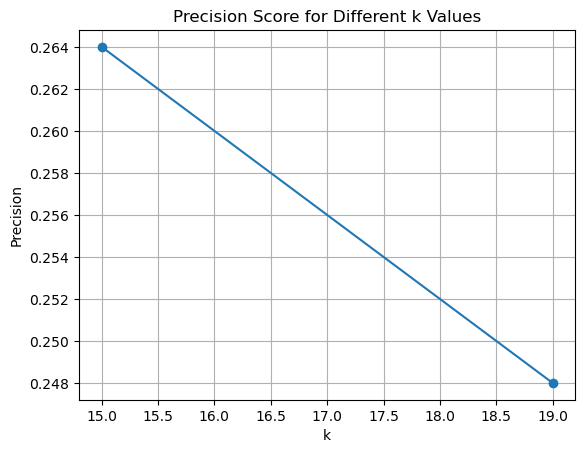

In [56]:
jaccard_moyen = [item[1] for item in precision]

# Plot precision scores against k values
plt.plot(k_values, jaccard_moyen, marker='o')
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('Precision Score for Different k Values')
plt.grid(True)
plt.show()


### 2.8 Influence du nb de topics prédits sur la précision


In [ ]:
# idem, takes time
# On fera une véritable recherche d'optimisation + tard avec MLFlow

precision4 = []
precision3 = []
for k in range(50, 151, 10): # pour un classifieur binaire il faut k impair, mais ici comme on veut
    print(f'k={k}', '\n')
    precision4.append((k, predict_tags_using_knn(k=k, n=4)))
    precision3.append((k, predict_tags_using_knn(k=k, n=3)))

    print('\n')


k=50 



k=60 



k=70 



k=80 



k=90 



k=100 



k=110 



k=120 



k=130 



k=140 



k=150 





In [ ]:
# pas touche !
# > 0.5 !!

# factoriser ?
score_max4 = 0
for k, result in precision4:
    print(f'For {k} neighbors : precision moyenne = {result}')
    if result > score_max4:
        score_max4 = result

score_max3 = 0
for k, result in precision3:
    print(f'For {k} neighbors : precision moyenne = {result}')
    if result > score_max3:
        score_max3 = result

print('\n', f' meilleur score (4 tags predits) = {score_max4}')
print('\n', f' meilleur score (3 tags predits) = {score_max3}')

# 26

# tester k > 100 ?
# test en reduisant le corpus de tags ? ou pas (conserver la richesse du corpus ?)
# tester ce qui prend le + de tps (1 predict = environ 10 secondes, trop long)



  meilleur score (4 tags predits) = 0

  meilleur score (3 tags predits) = 0


In [ ]:
# yes !

score_max4 = 0
for k, result in precision4:
    print(f'For {k} neighbors : precision moyenne = {result}')
    if result > score_max4:
        score_max4 = result


score_max3 = 0
for k, result in precision3:
    print(f'For {k} neighbors : precision moyenne = {result}')
    if result > score_max3:
        score_max3 = result


print('\n', f' meilleur score (4 tags predits) = {score_max4}')
print('\n', f' meilleur score (3 tags predits) = {score_max3}')

# near 60



  meilleur score (4 tags predits) = 0

  meilleur score (3 tags predits) = 0


### 2.9 Preprocessing (feature et target)


In [ ]:
# Nous avons besoin de transformer la target pdt le preprocessing (-> bow)
# mm si on ne s'sn sert pas vraiment, car grid_search.fit() n'accepte que des valeurs numériques.

# Avantage : on peut utiliser des metriques classiques pour le score (ici r2),
# mais ca n'a aucun sens metier interpretable.
# peut tjs etre utile si fortement correlé à notre precision score custom
# ou au score de similarité Jaccard

# Compliqué à faire dans le pipeline sckikit, qui transforme les features mais pas la target.
# TransformedTargetRegressor ne convient pas non plus ici : c'est un modele wrapper,
# utilisé apres le pipeline.
# trouvé qq "solutions" + ou - elegantes, mais rien de compatible à la fois avec sklearn et mlflow.

# Ici convertir les tags en bag of words ou les one hot encoder revient exactement au meme, donc
# autant utiliser le bow, on a deja le transformeur.
# En + avec la plupart des embedding on peut considerer que la prediction de topics devient
# un probleme de regression, les valeurs predites par les modeles sont des vecteurs
# dans un espace techniquement fini, mais immense.


In [ ]:
def token_list_into_bow(X):
    documents = X.tolist()
    # print(documents)
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    bow_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    return bow_matrix


### 2.10 (tentative de) gridsearch


In [ ]:
# Prend trop de ressources ! Il est tps d'utiliser les nested runs de mlflow.
# Parce qu'une gridsearch qui ne peut tester qu'une seule valeur pour un seul hyperparam a la fois,
# ce n'est pas tres utile...

# En plus je me demande si la gridsearch est une bonne idée pour le knn.
# deja pour la lda et la nmf j'avais des doutes
# a verifier mais pour ces modeles je pense qu'un dataset d'entrainement plus petit peut
# serieusement impacter le nb optimal pour l'hyperparam
# (voisins pour le knn, topics pour lda et nmf)

def pipe_knn(train_df=train_df, feature='title_nltk', target='all_tags', test_df=test_df, metric='cosine', graph=True):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].values

    X_bow_matrix = token_list_into_bow(X_train)
    y_bow_matrix = token_list_into_bow(y_train)

    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Create a pipeline with preprocessing and a knn regressor, to simplify gridsearch
    pipe = Pipeline(steps=[
        ("knn_regressor", knn_regressor)
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'knn_regressor__n_neighbors': [1],
        'knn_regressor__weights': ['uniform'] # , 'distance'
    }

    # Create the GridSearchCV object with multiple scoring metrics
    # scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}
    grid_search = GridSearchCV(pipe, param_grid=param_grid,
                            scoring='r2', cv=5, verbose=1) # add, refit='precision' for multiple scoring

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_bow_matrix, y_bow_matrix)

    # Access the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create the KNN regressor with the best hyperparameters
    best_knn_regressor = KNeighborsRegressor(# metric=metric,
                                             n_neighbors=best_params['knn_regressor__n_neighbors'],
                                             weights=best_params['knn_regressor__weights'])

    # Create a pipeline with the preprocessor and the tuned knn regressor
    pipeline_with_tuned_knn = Pipeline(steps=[
        ("knn_regressor", best_knn_regressor)  # Use the tuned neighbor and weight values here
    ])

    # Perform cross-validation (on training set) and display the scores for each split
    # scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_knn, X_bow_matrix, y_bow_matrix, cv=5, scoring='r2')
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    pprint(cv_scores)
    for i, score in enumerate(cv_scores['test_score']):
        print(f"Split {i+1} : precision = {score}")


# pipe_knn()


### 2.11 test mlflow run


In [ ]:
# Si erreur, commande console
# mlflow ui
# depuis dossier notebooks

experiment_id = create_mlflow_experiment(
    experiment_name="knn_optimisation",
    artifact_location="./artifacts",
    tags={"modele": "knn", "feature": "title", 'nlp': 'nltk'},
)


Experiment knn_optimisation already exists.


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=knn_optimisation (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f77b615ee90>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="testing", experiment_id=experiment_id) as run:

    # log model using autolog
    # mlflow.autolog()
    # mlflow.sklearn.autolog()
    # les 2 demandent trop de ressources, il faut logger manuellement.
    pipe_knn()

    # print run info
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))


# J'esperais qu'mlflow allait nous permettre de contourner le probleme de
# l'entrainement du modele, qui demande bcp d'espace memoire.
# probleme : mm sans l'ui, le tracking/logging mlflow consomment enormement !
# la solution a l'air pire que le probleme...


Name: knn_optimisation
Fitting 5 folds for each of 1 candidates, totalling 5 fits


: 

## Annexes, tests


### rf


In [ ]:
# test

from sklearn.preprocessing import MultiLabelBinarizer

def predict_tags_using_rf(train_df=train[::100], feature='title_nltk', target='all_tags', test_df=test, n_estimators=50):
    documents = train_df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Convert multi-label tags into binary format
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(train_df[target])

    # Fit Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(dense_matrix, y_encoded)

    # Predictions
    predictions = []
    min_range = 3000
    max_range = 3005
    for i in range(min_range, max_range):
        query_document = test_df[feature][i]
        print(f'doc {i} : {query_document}')
        print(f'real tags : {test[target][i]}')
        query_bow = gensim_dictionary.doc2bow(query_document)
        query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

        # Predict tags using Random Forest
        prediction_encoded = rf_model.predict(query_vector.reshape(1, -1))

        # Convert back to original tag format
        predicted_tags = mlb.inverse_transform(prediction_encoded.reshape(1, -1))

        predictions.append(predicted_tags)
        print(f'predicted : {predictions[-1]}', '\n')

    return predictions

# Call the function with your DataFrame and the desired text feature and target tags
predictions_rf = predict_tags_using_rf()


## Deep learning Models
